### Importing Necessary Libraries

In [9]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, MaxPool2D, Dense
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

### Data Loading and Preprocessing

In [10]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [11]:
X_train = train.drop(['label'],axis=1)
X_train = X_train/255.0
X_train = X_train.values.reshape(-1, 28, 28, 1)
y_train = tensorflow.keras.utils.to_categorical(train['label'], num_classes=10)

In [12]:
test = test / 255.0
test = test.values.reshape(-1, 28, 28, 1)

In [13]:
(X_train_MNIST, y_train_MNIST), (X_test_MNIST, y_test_MNIST) = mnist.load_data()
train_mnist = np.concatenate((X_train_MNIST, X_test_MNIST))
test_mnist = np.concatenate((y_train_MNIST, y_test_MNIST))

train_mnist = train_mnist.reshape(-1, 28, 28, 1)
train_mnist = train_mnist/255.0

test_mnist = tensorflow.keras.utils.to_categorical(test_mnist, num_classes=10)

images = np.concatenate((X_train, train_mnist))
labels = np.concatenate((y_train, test_mnist))

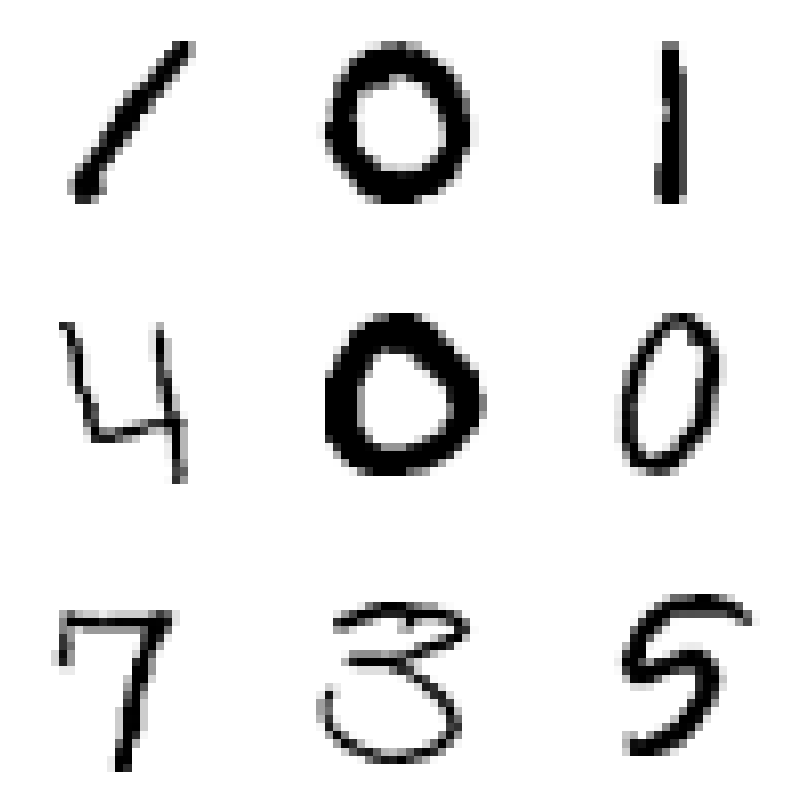

In [14]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.axis("off")
plt.show()

In [15]:
print(images.shape)
print(labels.shape)

(112000, 28, 28, 1)
(112000, 10)


### Data Augmentation

In [16]:
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, shear_range=15, zoom_range=0.1, validation_split=0.25)

In [17]:
train_dataset = datagen.flow(images, labels, batch_size=256, subset='training')

In [18]:
test_dataset = datagen.flow(images, labels, batch_size=64, subset='validation')

### Model Building

In [19]:
model = Sequential()

In [20]:
model.add(Conv2D(filters=32, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=2))

In [21]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

### Model Compilation and Training

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.000001)
checkpoint = ModelCheckpoint(filepath='model.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)

In [24]:
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset, callbacks=[reduce_lr, checkpoint])

Epoch 1/20
329/329 [==============================] - 51s 151ms/step - loss: 0.4464 - accuracy: 0.8478 - val_loss: 0.1088 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 2/20
329/329 [==============================] - 51s 154ms/step - loss: 0.1042 - accuracy: 0.9687 - val_loss: 0.0746 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 3/20
329/329 [==============================] - 51s 156ms/step - loss: 0.0753 - accuracy: 0.9776 - val_loss: 0.0586 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 4/20
329/329 [==============================] - 51s 154ms/step - loss: 0.0618 - accuracy: 0.9823 - val_loss: 0.0554 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 5/20
329/329 [==============================] - 50s 151ms/step - loss: 0.0567 - accuracy: 0.9838 - val_loss: 0.0436 - val_accuracy: 0.9878 - lr: 0.0010
Epoch 6/20
329/329 [==============================] - 50s 152ms/step - loss: 0.0499 - accuracy: 0.9856 - val_loss: 0.0431 - val_accuracy: 0.9879 - lr: 0.0010
Epoch 7/20
329/329 [==============================] 

### Plotting Training History

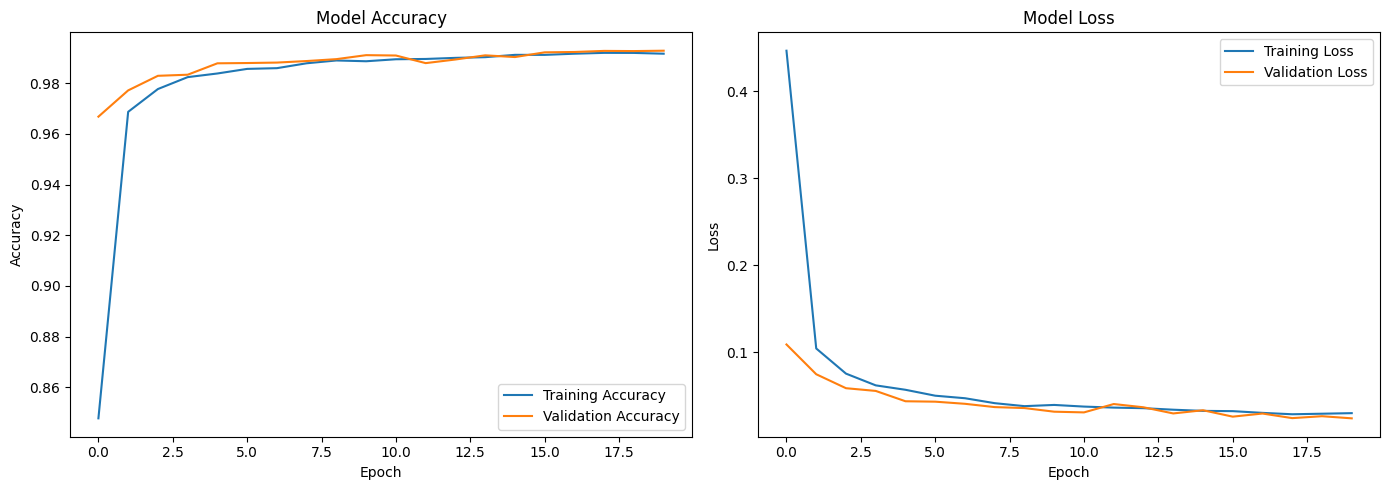

In [25]:
plt.figure(figsize=(14, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
test = pd.read_csv('test.csv')

test = np.array(test, dtype=np.float32)/255
test = test.reshape(-1,28,28,1)
prediction = model.predict(test)
predict = np.array(np.round(prediction), dtype = np.int32)
predict = np.argmax(predict , axis=1).reshape(-1, 1)
out = [{'ImageId': i+1, 'Label': predict[i][0]} for i in range(len(predict))]
pd.DataFrame(out).to_csv('submission.csv', index=False)

875/875 [==============================] - 6s 7ms/step
